Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed: int = 2024
    do_display: bool = True
    result_fname: str = ""
    m_train_examples: int = 1000
    m_test_examples: int = 1000
    score_name: str = "y"
    clean_up: bool = False
    show_console: bool = False
    generative_noise_scale: float = 0.87
    scoring_noise_scale: float = 2.0
    continue_inspection_probability: float = 0.8

In [2]:
# set up Python
import logging
import os
import json
from itertools import product
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from wvu.util import plot_roc, threshold_plot
from plotnine import *

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name: str = "small example"

In [5]:
if do_display:
    print(example_name)

small example


In [6]:
# read data and set scale of system


examples_frame = pd.read_csv("d_large.csv")

examples_frame

,x1,x2,y,presentation_group,sampled_positive
0,1.038658,0.008663,1,1,False
1,0.055176,0.827693,1,1,False
2,-0.183270,1.003654,1,1,True
3,1.048862,-0.208270,0,1,False
4,-0.130628,0.094156,0,1,False
...,...,...,...,...,...
999995,-0.051125,0.004166,0,200000,False
999996,1.217447,0.174052,0,200000,False
999997,0.987780,0.041584,1,200000,False
999998,0.059343,1.083677,1,200000,True


In [7]:
variable_names = [c for c in examples_frame.columns if c.startswith('x')]
n_item_features: int = len(variable_names)
group_sizes = examples_frame.groupby('presentation_group').size()
n_alternatives: int = int(np.max(group_sizes))
assert np.all(group_sizes == n_alternatives)

In [8]:
def mk_example(
    *,
    m_examples: int,
):
    groups = sorted(set(examples_frame['presentation_group']))
    sample = rng.choice(groups, size=m_examples, replace=True)
    return (
        examples_frame
            .loc[np.isin(examples_frame['presentation_group'], sample), :]
            .sort_values(
                ['presentation_group', 'sampled_positive', 'y'], 
                ascending=[True, False, False],
                ignore_index=True, 
                inplace=False,
            )
    )

In [9]:
observations_train = mk_example(m_examples=m_train_examples)

observations_train.head()

,x1,x2,y,presentation_group,sampled_positive
0,0.018783,0.914060,1,116,True
1,1.150784,0.071900,1,116,False
2,0.124434,1.093304,1,116,False
3,1.298226,0.049298,1,116,False
4,0.084244,0.003521,0,116,False


In [10]:

observations_test = mk_example(m_examples=m_test_examples)

observations_test.head()


,x1,x2,y,presentation_group,sampled_positive
0,-0.030772,0.914600,1,179,True
1,1.012660,-0.003719,1,179,False
2,-0.027100,-0.214783,0,179,False
3,0.225265,0.095680,0,179,False
4,-0.315568,-0.150670,0,179,False


Try a direct logistic regression on the uncensored proposed choices.

In [11]:
model_logistic_1 = LogisticRegression()
model_logistic_1.fit(
    observations_train.loc[:, variable_names],
    observations_train[score_name]
)
observations_test['unobservable_logistic_prediction'] = model_logistic_1.predict_proba(
    observations_test.loc[:, variable_names])[:, 1]

observations_test.head()

,x1,x2,y,presentation_group,sampled_positive,unobservable_logistic_prediction
0,-0.030772,0.914600,1,179,True,0.680026
1,1.012660,-0.003719,1,179,False,0.386532
2,-0.027100,-0.214783,0,179,False,0.313171
3,0.225265,0.095680,0,179,False,0.412534
4,-0.315568,-0.150670,0,179,False,0.330070


<Figure size 640x480 with 0 Axes>

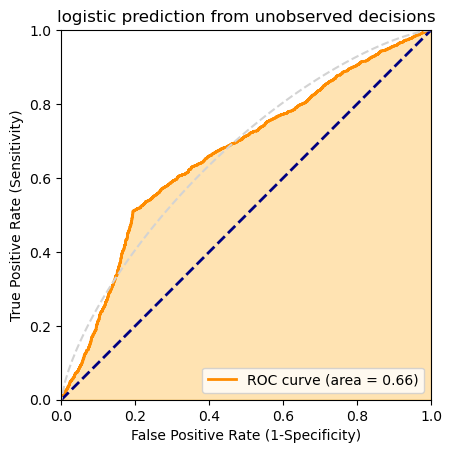

0.6644508571342439

In [12]:
plot_roc(
    prediction=observations_test["unobservable_logistic_prediction"],
    istrue=observations_test[score_name],
    ideal_line_color="lightgrey",
    title="logistic prediction from unobserved decisions",
)

Try a direct logistic prediction choices limited down to at most best one per group.


In [13]:
model_logistic_2 = LogisticRegression()
model_logistic_2.fit(
    observations_train.loc[:, variable_names],
    observations_train[score_name] * observations_train['sampled_positive']
)
observations_test['censored_logistic_prediction'] = model_logistic_2.predict_proba(
    observations_test.loc[:, variable_names])[:, 1]

observations_test.head()

,x1,x2,y,presentation_group,sampled_positive,unobservable_logistic_prediction,censored_logistic_prediction
0,-0.030772,0.914600,1,179,True,0.680026,0.464701
1,1.012660,-0.003719,1,179,False,0.386532,0.037024
2,-0.027100,-0.214783,0,179,False,0.313171,0.077326
3,0.225265,0.095680,0,179,False,0.412534,0.105955
4,-0.315568,-0.150670,0,179,False,0.330070,0.118199


<Figure size 640x480 with 0 Axes>

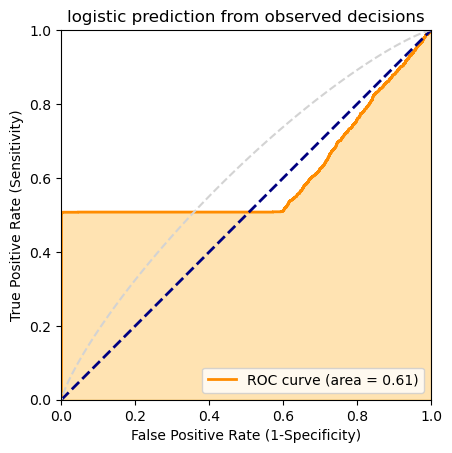

0.6069494372095007

In [14]:
plot_roc(
    prediction=observations_test["censored_logistic_prediction"],
    istrue=observations_test[score_name],
    ideal_line_color="lightgrey",
    title="logistic prediction from observed decisions",
)

Try a Stan to try and represent the selection presentation process.

In [15]:
# (for now) limit down to groups with a positive
groups_with_positive = (
    observations_train
        .groupby(['presentation_group'])
        ['sampled_positive']
        .max()
        .reset_index(drop=False, inplace=False)
)
groups_with_positive = list(
    groups_with_positive.loc[groups_with_positive['sampled_positive'], 'presentation_group']
)
observations_train_pos = (
    observations_train
        .loc[np.isin(observations_train['presentation_group'], groups_with_positive), :]
        .reset_index(drop=True, inplace=False)
        .sort_values(
            ['presentation_group', 'sampled_positive', 'y'], 
            ascending=[True, False, False],
            ignore_index=True, 
            inplace=False,
        )
)


In [16]:
def define_Stan_list_src(
    n_alternatives: int,
):
    stan_model_list_src = (
        """
data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
"""
        + "".join(
            [
                f"""  matrix[m_examples, n_vars] x_passed_{i};   // character of passed examples
"""
                for i in range(1, n_alternatives)
            ]
        )
        + f"""}}
parameters {{
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}}
transformed parameters {{
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  array[{n_alternatives-1}] vector[m_examples] expect_passed;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  v_picked = expect_picked + error_picked;  // reified actual score of picked item
"""
        + "".join(
            [
                f"""  expect_passed[{sel_j}] = x_passed_{sel_j} * beta;      // modeled expected score of passed item
"""
                for sel_j in range(1, n_alternatives)
            ]
        )
        + f"""}}
model {{
    // basic priors
  beta ~ normal(0, 10);
  error_picked ~ normal(0, 10);
    // log probability of observed ordering as a function of parameters
    // terms are independent conditioned on knowing value of v_picked!
  for (sel_j in 1:{n_alternatives-1}) {{
    target += normal_lcdf( v_picked | expect_passed[sel_j], 10);
  }}
}}
"""
    )
    return stan_model_list_src

stan_model_src = define_Stan_list_src(n_alternatives=n_alternatives)

print(stan_model_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  array[4] vector[m_examples] expect_passed;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  v_picked = expect_picked + error_picked;  // reified actual score of p

In [17]:
def format_Stan_data(
):
    m_observations = int(observations_train_pos.shape[0] / n_alternatives)

    def fmt_x_block(sel_j: int):
        x_block = observations_train_pos.loc[
            [sel_j + n_alternatives * group_i for group_i in range(m_observations)], 
            variable_names]
        return json.dumps([list(v) for v in list(np.array(x_block))])

    data_str = (f"""
{{
 "n_vars" : {n_item_features},
 "m_examples" : {m_observations},
 "x_picked" : {fmt_x_block(0)},
"""
    + ",\n".join([f' "x_passed_{sel_j}" : {fmt_x_block(sel_j)}' for sel_j in range(1, n_alternatives)])
    + """
}
""")
    return data_str

data_str = format_Stan_data()

print(data_str)


{
 "n_vars" : 2,
 "m_examples" : 952,
 "x_picked" : [[0.018783472833682, 0.914059949296882], [0.353866412755413, 0.911032649819739], [-0.0023941376772875, 1.05697523267507], [-0.0119129963969072, 1.07235079813722], [1.02188232838363, 0.0500905490055088], [-0.0302308057199975, 0.996633034061713], [-0.172337770194273, 1.05882294878339], [0.898947075352952, 0.0316483507521217], [0.0768527142124177, 0.87356191734074], [0.0180975907367358, 1.05237010765465], [0.0324626758272479, 1.00847373232758], [-0.0377194066276058, 1.01032614373335], [0.0256609573734713, 1.07292163897818], [-0.0499138383010332, 0.99246850930008], [-0.094560869679764, 0.889468099892073], [-0.0075251371651257, 1.07115901147601], [0.0829035336061364, 0.949647330806337], [0.0241046380118168, 0.946669647865165], [-0.0854817298342993, 1.00768917136909], [0.0658775571382087, 1.09156171736463], [0.0152855641064865, 1.04758845784759], [-0.186108881207989, 0.902446677858095], [0.0857355224717236, 0.833793414060968], [0.247259584

In [18]:
def run_stan_model(
    stan_model_src: str,
    *,
    data_str: str,
    clean_up: bool = True,
    model_note: str = '',
    show_progress: bool = False,
    show_console: bool = False,
):
    # build model
    # export source and data
    stan_file = f"rank_src_{model_note}_tmp.stan"
    data_file = f"rank_data_{model_note}_tmp.json"
    with open(stan_file, "w", encoding="utf8") as file:
        file.write(stan_model_src)
    with open(data_file, "w", encoding="utf8") as file:
        file.write(data_str)
    # instantiate the model object
    model_comp = CmdStanModel(stan_file=stan_file)
    # fit to data
    fit = model_comp.sample(
        data=data_file,
        show_progress=show_progress,
        show_console=show_console,
    )
    if clean_up:
        os.remove(stan_file)
        os.remove(data_file)
    return fit

In [19]:
fit = run_stan_model(
    stan_model_src=stan_model_src,
    data_str=data_str,
    model_note='small_test',
)

In [20]:
draws = fit.draws_pd(vars=['lp__', 'beta'])

draws

,lp__,beta[1],beta[2]
0,-1210.64,-7.90790,17.0349
1,-1191.17,-8.03591,17.1351
2,-1174.06,-7.44742,16.5275
3,-1220.13,-7.97390,17.5637
4,-1212.85,-6.81815,16.5869
...,...,...,...
3995,-1167.00,-8.17538,15.4746
3996,-1172.39,-7.49765,16.1376
3997,-1196.08,-8.81767,16.2215
3998,-1170.71,-8.31463,16.1629


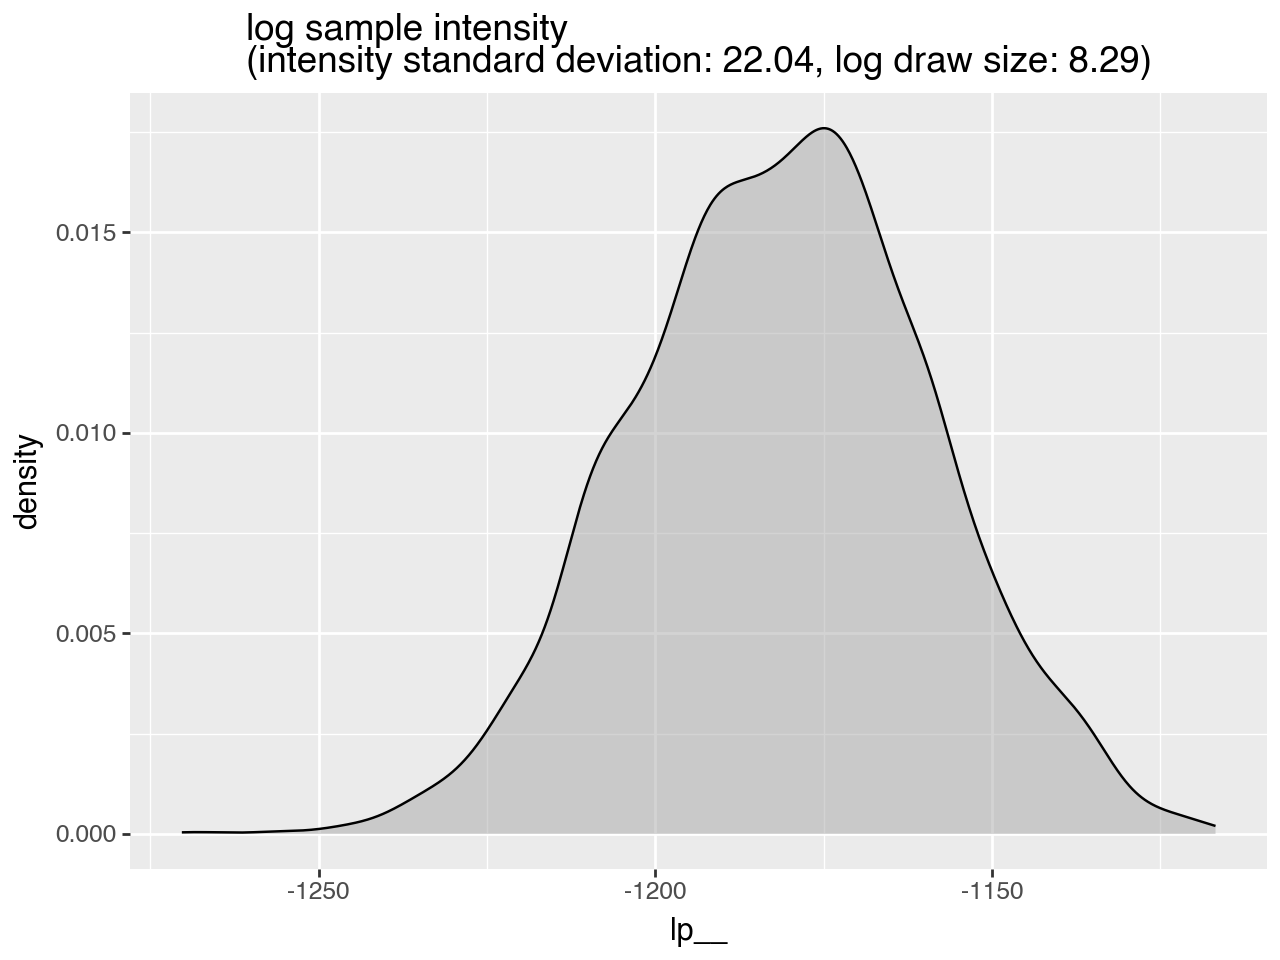

In [21]:
sd_sample_density = np.std(draws['lp__'])
log_draw_size = np.log(draws.shape[0])
(
    ggplot(
        data=draws,
        mapping=aes(x='lp__')
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle(f"log sample intensity\n(intensity standard deviation: {sd_sample_density:.2f}, log draw size: {log_draw_size:.2f})")
)

In [22]:
coefs = np.array(
    draws.loc[:, [f'beta[{var_j+1}]' for var_j in range(n_item_features)]].mean())

coefs

array([-7.7580529 , 16.43683225])

In [23]:
observations_test['Stan_score'] = observations_test.loc[:, variable_names] @ coefs

In [26]:
observations_test.head()

,x1,x2,y,presentation_group,sampled_positive,unobservable_logistic_prediction,censored_logistic_prediction,Stan_score
0,-0.030772,0.914600,1,179,True,0.680026,0.464701,15.271850
1,1.012660,-0.003719,1,179,False,0.386532,0.037024,-7.917405
2,-0.027100,-0.214783,0,179,False,0.313171,0.077326,-3.320111
3,0.225265,0.095680,0,179,False,0.412534,0.105955,-0.174943
4,-0.315568,-0.150670,0,179,False,0.330070,0.118199,-0.028337


<Figure size 640x480 with 0 Axes>

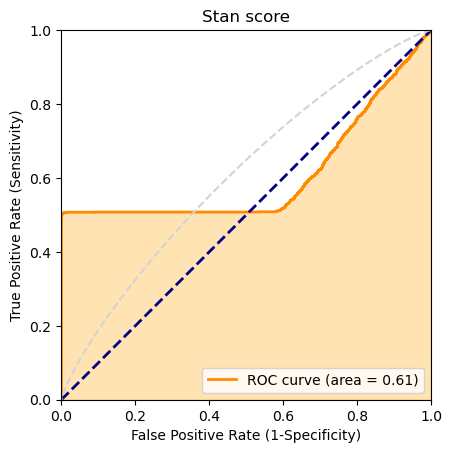

0.6070988860926911

In [25]:
plot_roc(
    prediction=observations_test["Stan_score"],
    istrue=observations_test[score_name],
    ideal_line_color="lightgrey",
    title="Stan score",
)